# 第7周：线性模型

完成以下题目:
*  学习理解如何用最小二乘法的矩阵公式来得到线性回归的解，并使用numpy库来实现该算法。
*  使用pandas库中的函数下载上证综指和任一成份股票数据，计算日收益率，对这两组数据建立回归模型，将上证综指的收益率作为解释变量，说明这个模型的用处。
*  在kaggle网站上找到titanic数据，并使用logistic回归来建模，研究分析每个因素对应生存的重要性。
*  搜集某个城市过去1个月的PM2.5小时级数据，根据时间序列预测方法，来预测未来三天的PM2.5情况。

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

## 1.最小二乘法  

学习理解如何用最小二乘法的矩阵公式来得到线性回归的解，并使用numpy库来实现该算法。

### 1.1 什么是最小二乘法

最小二乘法的核心思想是“保证所有数据残差平方和最小”。  
通俗来说，就是给定样本数据，寻找一条拟合曲线，保证每个样本点与对应的拟合值残差的平方和最小，这条曲线就是这些数据的最佳拟合曲线，而这种方法就是“最小二乘法”。  
附：有关残差、离差  
[方差 残差 离差 ](http://blog.csdn.net/myl1992/article/details/45866205)  
[离差 、方差、标准差、残差、误差](http://f.dataguru.cn/thread-287374-1-1.html)

### 1.2 数学表达

**一元线性回归模型：**  

$y_t = \beta_0 + \beta_1x_t + \mu_t (t=1,2,...,T)$  

其中，$T$为样本个个数，$x$为解释变量，$y$为被解释变量，$\mu$是误差项，它体现了$y$中没被$x$解释的部分。  

假设已经观测到了变量$x,y$的$T$个样本值$x_t,y_t$，要对上述模型中的参数进行估计。  

假设已经的到了$\beta_0,\beta_1$的估计值$b_0,b_1$，则样本回归函数为：  

$\hat{y} = b_0 + b_1*x_t$，  

是对总体回归函数的估计。残差：$\hat{\mu}$为：$\hat{\mu} = y_t-b_0-b_1\*x_t$  

要保证回归值与实际观测值尽可能相近，最小二乘法（OLS）就是通过使残差平方和（RSS）最小求出回归系数的估计值：  

$RSS = \sum_{t=1}^{T} \hat{\mu}^2 = \sum_{t=1}^{T} (y_t-b_0-b_1*x_t)^2$，  

$RSS$对$b_0,b_1$一阶偏导等于0时，$RSS$达到最小，即：  

${\frac 1T} \sum_{t=1}^{T} \hat{\mu}={\frac 1T} \sum_{t=1}^{T} (y_t-b_0-b_1*x_t) $  
${\frac 1T} \sum_{t=1}^{T} x_t\hat{\mu}={\frac 1T} \sum_{t=1}^{T} x_t(y_t-b_0-b_1*x_t) $   

联立求解可解出$b_0,b_1$为：  

$b_0 = \overline{y}-b_1 \overline{x}$  
$b_1 = {\frac {\sum_{t=1}^{T}(x-\overline{x})(y-\overline{y})}{\sum_{t=1}^{T} (x-\overline{x})^2}}$，  

其中：  
$\overline{x}={\frac 1T \sum_{t=1}^{T}x_t} $, $\overline{y}={\frac 1T \sum_{t=1}^{T}y_t} $  

随机误差项为：  

$\hat{\mu}^2 = {\frac {\sum_{t=1}^{T}\hat{\mu_t}^2}{T-2}}$，  

$T-2$的原因是在利用最小二乘法进行参数估计时，为了使$RSS$最小，对残差序列施加了两个限制条件（上述联立方程组），样本损失两个自由度。

**多元线性回归模型：**  

$y_t = \beta_0 + \beta_1x_{1t}+ \beta_2x_{2t} +...+ \beta_kx_{kt} \mu_t (t=1,2,...,T)$  

习惯上，一般写为矩阵形式：  

${\bf Y =X\beta + \mu}$  

其中，${\bf Y}$为因变量观测值的T维变量；${\bf X}$时所有自变量的T个样本点观测值组成的${T*(k+1)}$矩阵；${\bf \beta}$是k+1维系数向量，${\bf \mu}$为T维扰动项向量。  

运用OLS：  

$ RSS = {\sum_{t=1}^{T}\hat{\mu_t}^2} = {\bf \hat{\mu}\prime} \hat{\mu} = ({\bf Y-Xb})\prime({\bf Y-Xb})$  


$ {\bf b} = {\bf (X\prime X)^{-1} X\prime Y}$  

$\hat{\sigma}^2 = {\frac {\sum\hat{\mu_i}^2}{T-k-1}}$    （k+1）个限制条件。

### 1.3 numpy实现

In [47]:
np.random.seed(123456789)

In [48]:
y = np.array([1,2,3,4,5])

In [49]:
x1 = np.array([6,7,8,9,10])

In [50]:
x2 = np.array([11,12,13,14,15])

In [51]:
X = np.vstack([np.ones(5),x1,x2,x1*x2]).T

In [52]:
X

array([[   1.,    6.,   11.,   66.],
       [   1.,    7.,   12.,   84.],
       [   1.,    8.,   13.,  104.],
       [   1.,    9.,   14.,  126.],
       [   1.,   10.,   15.,  150.]])

In [53]:
def OLSNumpy(X,y):
    invX = np.mat(np.dot(X.T,X)).I
    b = np.dot(np.dot(invX,X.T),y)
    return b

In [54]:
def OLSNumpy2(X, y):
#    X = np.vstack([x, np.ones(len(x))]).T
    invX2 = np.linalg.inv(X.T.dot(X))
    b2=(invX2.dot(X.T)).dot(y)
    return b2

**注意：两种求逆矩阵的方法结果并不一致：**

In [58]:
def olstest(X,y):
    b = np.dot(np.dot(inv(np.dot(X.T,X)),X.T),y)
    return b

In [59]:
olstest(X,y)

array([ -2.88868146e-01,   1.80729334e+00,  -1.27604334e+00,
        -8.43769499e-15])

In [55]:
from numpy.linalg import inv

def ols(X_matrix, y):
    '''
    returns coeff array by using OLS closed-form matrix formula
    X_matrix: design matrix
    y: column raw data
    '''
    w = inv(np.dot(X_matrix.T,X_matrix)).dot(X_matrix.T).dot(y)
    return w

In [56]:
ols(X,y)

array([ -2.88868146e-01,   1.80729334e+00,  -1.27604334e+00,
        -8.43769499e-15])

In [85]:
invX = np.mat(np.dot(X.T,X)).I
invX

matrix([[ -5.67547895e+14,  -1.13509579e+14,   1.13509579e+14,
          -2.54564213e+00],
        [ -1.13509579e+14,  -2.27019158e+13,   2.27019158e+13,
          -2.89527229e+00],
        [  1.13509579e+14,   2.27019158e+13,  -2.27019158e+13,
           1.39528381e+00],
        [  5.15974769e+00,  -1.35376475e+00,  -1.46235252e-01,
           7.14285714e-02]])

In [88]:
invX2 = np.linalg.inv(X.T.dot(X))
invX2

array([[ -5.67547895e+14,  -1.13509579e+14,   1.13509579e+14,
         -2.54654069e+00],
       [ -1.13509579e+14,  -2.27019158e+13,   2.27019158e+13,
         -2.89502242e+00],
       [  1.13509579e+14,   2.27019158e+13,  -2.27019158e+13,
          1.39502242e+00],
       [  5.15974769e+00,  -1.35376475e+00,  -1.46235252e-01,
          7.14285714e-02]])

In [99]:
invX == invX2

matrix([[False,  True, False, False],
        [False, False,  True, False],
        [False,  True,  True, False],
        [ True,  True, False,  True]], dtype=bool)

In [100]:
OLSNumpy(X,y)

matrix([[ -2.51521444e+00,   1.29502610e+00,  -4.93047177e-01,
          -5.77315973e-15]])

In [101]:
OLSNumpy2(X,y)

array([ -2.88868146e-01,   1.80729334e+00,  -1.27604334e+00,
        -8.43769499e-15])

In [39]:
model = sm.OLS(y,X)
result = model.fit()

In [40]:
result.params

array([ -5.55555556e-01,   1.88888889e+00,  -8.88888889e-01,
        -1.11022302e-15])

可以发现，几种方法的出来的结果不太一样，可能是算法不同导致。

### 1.4 小结  

1. 几个关于矩阵乘法，逆矩阵的帖子：  
  *  [NumPy函数库基础](http://www.ituring.com.cn/article/2162)  
  *  [矩阵对象](http://keeng2008.blog.163.com/blog/static/52832902008111323632863/)  
  *  [科学计算：Python VS. MATLAB(3)----线性代数基础](http://blog.sina.com.cn/s/blog_5f234d4701012p64.html)
2. 关于最小二乘法的帖子：  
  *  [最小二乘法？为神马不是差的绝对值](http://blog.sciencenet.cn/blog-430956-621997.html)  
3. 用矩阵理解最小二乘法更加便捷容易。

## 2.线性回归  

使用pandas库中的函数下载上证综指和任一成份股票数据，计算日收益率，对这两组数据建立回归模型，将上证综指的收益率作为解释变量，说明这个模型的用处。

### 2.1 理论分析  

#### 2.1.1 基本概念  
*  成份股  
   通过对股票市场上一些有代表性的公司发行的股票价格进行平均计算和动态对比后得出的数值被称为股票价格指数。股票价格指数能综合考察股票市场的动态变化过程，反映股票市场的价格水平，为社会公众提供股票投资和合法的股票增值活动的参考依据。那么，这些有代表性的公司股票被笼统的称为成份股。成分股就是一整套股票里的每只，比如50etf里的股票就叫50etf的成分股。
   上证180指数和深证100指数就是沪、深股市中两个具有典型代表性的指数，而构成上述指数的股票就分别称为上证180指数成份股和深圳100指数成份股。
   深圳证券交易所对在该所上市的公司进行考查，按一定标准选出40家有代表性的上市公司编制成份股指数。这40家公司即叫成份股（即被选为成份股指数的股票）。选股标准是根据股票所属行业，业绩，成长性等方面来决定的。  
   详细见[百度百科：成份股](http://baike.baidu.com/view/1297529.htm)   
*  上证50成份股  
   **本题目中，我们选取上证50指数作为分析对象**  
   上证50指数是根据科学客观的方法，挑选上海证券市场规模大、流动性好的最具代表性的50只股票组成样本股，以便综合反映上海证券市场最具市场影响力的一批龙头企业的整体状况。上证50指数自2004年1月2日起正式发布。其目标是建立一个成交活跃、规模较大、主要作为衍生金融工具基础的投资指数。  
   [上证50指数成分股列表 ](http://www.sse.com.cn/market/sseindex/indexlist/s/i000016/const_list.shtml)  
   在上面的网站中，我们也可以选择其他各种各样的成份股（如上证100,150,180,380等等）。  
#### 2.2.2 业务逻辑  
1. 用上证综指收益率作为解释变量（自变量），上证50指数收益率作为被解释变量（因变量）。  
2. 上证50指数为龙头企业，最具有市场影响力。因此，我们可以大概判断，上证综指收益率与上证50指数收益率正相关。

In [133]:
import tushare as ts
import datetime

### 2.2 实证分析

#### 2.2.1 获取数据

In [138]:
sh = ts.get_hist_data('sh'); # 大盘指数

In [139]:
sz50 = ts.get_hist_data('sz50'); # 上证50

#### 2.2.2 探索数据

In [142]:
sh.head()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
date,,,,,,,,,,,,,
2016-06-17,2873.01,2900.30,2885.11,2872.18,1714725.12,12.29,0.43,2864.080,2898.161,2869.524,1602074.12,1550802.67,1420563.90
2016-06-16,2878.40,2887.74,2872.82,2865.39,1738827.62,-14.39,-0.50,2872.490,2901.001,2865.644,1545221.25,1567716.59,1405071.56
2016-06-15,2814.69,2894.26,2887.21,2811.78,1666710.75,45.02,1.58,2885.134,2905.381,2864.187,1463431.45,1609094.18,1379814.71
2016-06-14,2824.23,2843.46,2842.19,2822.06,1197552.75,9.12,0.32,2894.512,2898.905,2862.370,1414076.78,1548742.69,1353805.96
2016-06-13,2897.27,2911.16,2833.07,2832.51,1692554.38,-94.09,-3.21,2913.810,2896.791,2861.616,1518608.28,1538833.24,1351088.18


In [141]:
sz50.head()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
date,,,,,,,,,,,,,
2016-06-17,2093.69,2115.42,2102.20,2093.69,178460.81,7.39,0.35,2096.592,2118.160,2104.866,183497.12,172764.50,173558.39
2016-06-16,2095.36,2105.25,2094.81,2091.49,179688.61,-11.82,-0.56,2102.744,2121.836,2103.694,180616.54,180391.74,176153.91
2016-06-15,2073.47,2115.38,2106.63,2073.10,195499.25,11.61,0.55,2111.596,2127.921,2102.727,172815.80,203074.62,174594.96
2016-06-14,2080.90,2098.06,2095.02,2079.40,153549.23,10.72,0.51,2117.534,2126.474,2101.527,161033.63,201239.08,171609.62
2016-06-13,2113.91,2122.46,2084.30,2083.29,210287.70,-48.66,-2.28,2129.058,2124.464,2100.585,171376.08,196461.65,171576.09


In [143]:
sz50.head()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
date,,,,,,,,,,,,,
2016-06-17,2093.69,2115.42,2102.20,2093.69,178460.81,7.39,0.35,2096.592,2118.160,2104.866,183497.12,172764.50,173558.39
2016-06-16,2095.36,2105.25,2094.81,2091.49,179688.61,-11.82,-0.56,2102.744,2121.836,2103.694,180616.54,180391.74,176153.91
2016-06-15,2073.47,2115.38,2106.63,2073.10,195499.25,11.61,0.55,2111.596,2127.921,2102.727,172815.80,203074.62,174594.96
2016-06-14,2080.90,2098.06,2095.02,2079.40,153549.23,10.72,0.51,2117.534,2126.474,2101.527,161033.63,201239.08,171609.62
2016-06-13,2113.91,2122.46,2084.30,2083.29,210287.70,-48.66,-2.28,2129.058,2124.464,2100.585,171376.08,196461.65,171576.09


In [144]:
sh.describe()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
count,733.000000,733.000000,733.000000,733.000000,7.330000e+02,733.000000,733.000000,733.000000,733.000000,733.000000,7.330000e+02,7.330000e+02,7.330000e+02
mean,2807.745329,2839.687176,2812.838920,2776.565104,2.447542e+06,0.989501,0.056003,2810.766838,2807.931321,2802.022892,2.445118e+06,2.443055e+06,2.439315e+06
std,773.735014,791.075359,774.922992,751.647882,1.725700e+06,62.296905,1.799908,773.633959,772.365563,769.547405,1.677866e+06,1.652700e+06,1.622680e+06
min,1935.516000,1959.158000,1950.013000,1849.653000,5.627125e+05,-345.350000,-8.490000,1960.691000,1980.786000,2002.162000,6.472277e+05,6.787720e+05,7.066635e+05
25%,2103.828000,2116.186000,2105.062000,2093.197000,1.095539e+06,-15.315000,-0.610000,2103.694000,2100.190000,2086.157000,1.136142e+06,1.114631e+06,1.106629e+06
50%,2754.810000,2784.750000,2749.790000,2715.870000,1.862358e+06,2.416000,0.100000,2763.424000,2777.278000,2756.215000,1.899201e+06,1.929894e+06,1.935672e+06
75%,3292.290000,3338.300000,3305.738000,3267.509000,3.257635e+06,21.552000,0.870000,3295.282000,3290.754000,3290.264000,3.241587e+06,3.299648e+06,3.339850e+06
max,5174.418000,5178.191000,5166.350000,5103.401000,8.571328e+06,224.190000,5.760000,5127.879000,5052.792000,4925.927000,7.287152e+06,6.936106e+06,6.499393e+06


In [145]:
sz50.describe()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
count,733.000000,733.000000,733.000000,733.000000,7.330000e+02,733.000000,733.000000,733.000000,733.000000,733.000000,7.330000e+02,7.330000e+02,7.330000e+02
mean,2018.715829,2043.851750,2020.994082,1995.011121,5.884549e+05,0.542813,0.047190,2019.806794,2018.092754,2014.391442,5.884411e+05,5.886519e+05,5.890872e+05
std,518.500380,530.407544,518.464580,504.018566,5.722674e+05,45.426167,1.921839,517.205394,516.081680,513.843312,5.499082e+05,5.363932e+05,5.174688e+05
min,1402.813000,1420.901000,1406.915000,1402.182000,1.057749e+05,-247.750000,-9.380000,1420.818000,1424.709000,1440.795000,1.251453e+05,1.314226e+05,1.380674e+05
25%,1573.912000,1592.320000,1577.425000,1565.522000,2.087298e+05,-13.873000,-0.760000,1582.297000,1578.748000,1566.928000,2.225715e+05,2.350376e+05,2.367816e+05
50%,1951.680000,1986.720000,1955.400000,1929.810000,3.313522e+05,-0.110000,-0.010000,1969.842000,1977.756000,1976.562000,3.249236e+05,3.356945e+05,3.444877e+05
75%,2389.843000,2423.348000,2395.580000,2356.940000,7.753136e+05,16.533000,0.900000,2391.633000,2400.342000,2405.944000,7.856486e+05,7.778354e+05,8.340368e+05
max,3494.823000,3494.823000,3458.707000,3376.025000,3.774594e+06,191.660000,7.840000,3388.090000,3330.268000,3282.768000,3.280074e+06,2.656336e+06,2.149045e+06


In [146]:
sh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 733 entries, 2016-06-17 to 2013-06-19
Data columns (total 13 columns):
open            733 non-null float64
high            733 non-null float64
close           733 non-null float64
low             733 non-null float64
volume          733 non-null float64
price_change    733 non-null float64
p_change        733 non-null float64
ma5             733 non-null float64
ma10            733 non-null float64
ma20            733 non-null float64
v_ma5           733 non-null float64
v_ma10          733 non-null float64
v_ma20          733 non-null float64
dtypes: float64(13)
memory usage: 80.2+ KB


In [147]:
sz50.info()

<class 'pandas.core.frame.DataFrame'>
Index: 733 entries, 2016-06-17 to 2013-06-19
Data columns (total 13 columns):
open            733 non-null float64
high            733 non-null float64
close           733 non-null float64
low             733 non-null float64
volume          733 non-null float64
price_change    733 non-null float64
p_change        733 non-null float64
ma5             733 non-null float64
ma10            733 non-null float64
ma20            733 non-null float64
v_ma5           733 non-null float64
v_ma10          733 non-null float64
v_ma20          733 non-null float64
dtypes: float64(13)
memory usage: 80.2+ KB


#### 2.2.3 数据预处理

**1. 按时间先后重新排序**

In [148]:
sh = sh.sort_index()

In [149]:
sz50 = sz50.sort_index()

**2. 提取收益率数据**

In [156]:
sh_r = sh["p_change"]

In [157]:
sz50_r = sz50["p_change"]

#### 2.2.4 通过散点图观察数据    

可以很直观的对数据有个整体印象，便于进一步分析。

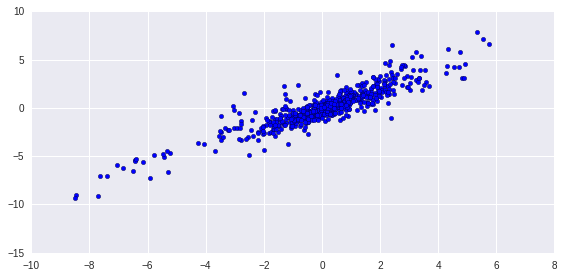

In [160]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.scatter(sh_r,sz50_r)

fig.tight_layout()

# 线性关系非常明显。

#### 2.2.5 建立线性模型

In [168]:
data = pd.DataFrame({"x":sh_r,"y":sz50_r})

In [169]:
model1 = smf.ols("y ~ x", data)
result1 = model1.fit()

In [177]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     3376.
Date:                Mon, 20 Jun 2016   Prob (F-statistic):          3.37e-276
Time:                        00:17:10   Log-Likelihood:                -885.84
No. Observations:                 733   AIC:                             1776.
Df Residuals:                     731   BIC:                             1785.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0070      0.030     -0.234      0.815        -0.066     0.052
x              0.9681      0.017     58.104      0.000         0.935     1.001
==============================================================================
Omnibus:                      152.929   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              569.867
Skew:                           0.940   Prob(JB):                    1.80e-124
Kurtosis:                       6.889   Cond. No.                         1.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

截距项不显著，考虑到与实际情况也不相符，果断剔除。

#### 2.2.6 模型改进

In [172]:
model2 = smf.ols("y ~ -1+ x", data)
result2 = model2.fit()

In [173]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     3383.
Date:                Mon, 20 Jun 2016   Prob (F-statistic):          1.17e-276
Time:                        00:14:38   Log-Likelihood:                -885.87
No. Observations:                 733   AIC:                             1774.
Df Residuals:                     732   BIC:                             1778.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x              0.9679      0.017     58.162      0.000         0.935     1.001
==============================================================================
Omnibus:                      152.937   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              569.894
Skew:                           0.940   Prob(JB):                    1.77e-124
Kurtosis:                       6.889   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RSS没有多大变化，但是F值t值显示模型和参数拟合效果较好。

#### 2.2.7 模型检验

In [174]:
z, p = stats.normaltest(result2.resid.values)

In [176]:
p

6.1689948897920652e-34

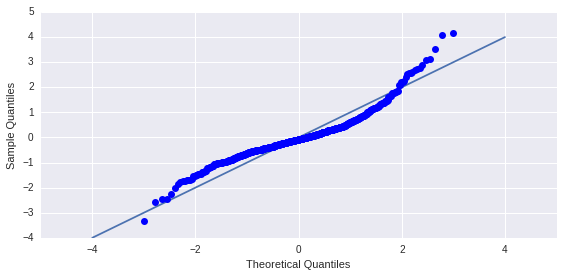

In [179]:
fig, ax = plt.subplots(figsize=(8,4))

x= np.linspace(-4,4,100)
y = x
ax.plot(x,y)
smg.qqplot(result2.resid, ax=ax)

fig.tight_layout()

p很小，拒绝原假设，说明残差服从正态分布。  
Q-Q图也可以看出残差服从正态分布。

### 2.3 小结  
1. 模型为：$ y = 0.9679*x$，可以看出上证50和上证综指收益率几乎是1:1在变动，两者相关性很高。  
2. 模型的高度相关性也从另一个角度映证了上证50的代表性，可谓上证晴雨表。  
3. **模型的结果仅仅只能说明两组数据收益率具有一定程度的相关性，并不能说明两者有因果关系。(特别注意)**  
4. 此模型为单变量回归模型，不涉及时间，自变量和因变量其实具有类似的“驱动因素”（因为都是收益率，而且上证50还包括在上证综指中）。因此，其实我们可以不需要实证就很迅速地得出结论：两者一定是强正相关的。

## 3.logistic回归  

在kaggle网站上找到titanic数据，并使用logistic回归来建模，研究分析每个因素对应生存的重要性。

### 3.1 背景分析  

故事情节早已深入内心，本次分析主要是根据提供的与乘客及此次事故有关的数据，判断乘客存活情况。  
初步判断可以采用多因素logistic回归模型进行分析。

### 3.2 读取数据并初步探索  

从网站上下载数据后读入。

In [180]:
!head -n 5 train.csv

In [181]:
!wc -l train.csv

892 train.csv


官方说明：  

VARIABLE DESCRIPTIONS:  
survival        Survival  
                (0 = No; 1 = Yes)  
pclass          Passenger Class  
                (1 = 1st; 2 = 2nd; 3 = 3rd)  
name            Name  
sex             Sex  
age             Age  
sibsp           Number of Siblings/Spouses Aboard  
parch           Number of Parents/Children Aboard  
ticket          Ticket Number  
fare            Passenger Fare  
cabin           Cabin  
embarked        Port of Embarkation  
                (C = Cherbourg; Q = Queenstown; S = Southampton)  

SPECIAL NOTES:  
Pclass is a proxy for socio-economic status (SES)  
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower  

Age is in Years; Fractional if Age less than One (1)  
 If the Age is Estimated, it is in the form xx.5  

With respect to the family relation variables (i.e. sibsp and parch)  
some relations were ignored.  The following are the definitions used  
for sibsp and parch.  

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic  
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)  
Parent:   Mother or Father of Passenger Aboard Titanic  
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic  

Other family relatives excluded from this study include cousins,  
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled  
only with a nanny, therefore parch=0 for them.  As well, some  
travelled with very close friends or neighbors in a village, however,  
the definitions do not support such relations.  

In [182]:
train = pd.read_csv("train.csv", delimiter=",", encoding=None, header=0)

In [184]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [185]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [187]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


可以发现数据包括：  ID号，是否存活，收入阶层，年龄，sibsp（兄弟姐妹数/配偶数），parch（父母数/儿童数），票号，票价 ，舱号，登船港口等列。

### 3.3 数据预处理  

处理原则：  
1. 尽可能保留指标，不随意剔除。  
2. 剔除缺失数据较多的指标，以及明显与存活率无太多相关性的指标。  

处理如下：  
1. 剔除Cabin，数据缺失较多。剔除name和Embarked，与结果没太多关系。剔除ticket，不好标准化，考虑票价可以代替。  
2. 剔除无年龄数据的行。

In [210]:
train1 = train.drop(train.columns[[3,8,10,11]],axis=1)

In [202]:
train1.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,male,22.0,1,0,7.2500
1,2,1,1,female,38.0,1,0,71.2833
2,3,1,3,female,26.0,0,0,7.9250
3,4,1,1,female,35.0,1,0,53.1000
4,5,0,3,male,35.0,0,0,8.0500


In [211]:
#df_subset.Species = df_subset.Species.map({"versicolor":1, "virginica":0})

train1["Sex"] = train1["Sex"].apply(lambda x: x == "male",1,0)

In [213]:
train1.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,True,22.0,1,0,7.2500
1,2,1,1,False,38.0,1,0,71.2833
2,3,1,3,False,26.0,0,0,7.9250
3,4,1,1,False,35.0,1,0,53.1000
4,5,0,3,True,35.0,0,0,8.0500


In [217]:
train1["Sex"] = (train1["Sex"]).astype(np.float)

In [218]:
train1.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,1.0,22.0,1,0,7.2500
1,2,1,1,0.0,38.0,1,0,71.2833
2,3,1,3,0.0,26.0,0,0,7.9250
3,4,1,1,0.0,35.0,1,0,53.1000
4,5,0,3,1.0,35.0,0,0,8.0500


In [219]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null float64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
dtypes: float64(3), int64(5)
memory usage: 55.8 KB


In [220]:
train1["SibSp"] = (train1["SibSp"]).astype(np.float)

In [221]:
train1["Parch"] = (train1["Parch"]).astype(np.float)

In [224]:
train1["Pclass"] = (train1["Pclass"]).astype(np.float)

In [225]:
train1["Survived"] = (train1["Survived"]).astype(np.float)

In [226]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
PassengerId    891 non-null int64
Survived       891 non-null float64
Pclass         891 non-null float64
Sex            891 non-null float64
Age            714 non-null float64
SibSp          891 non-null float64
Parch          891 non-null float64
Fare           891 non-null float64
dtypes: float64(7), int64(1)
memory usage: 55.8 KB


In [227]:
train1.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0.0,3.0,1.0,22.0,1.0,0.0,7.2500
1,2,1.0,1.0,0.0,38.0,1.0,0.0,71.2833
2,3,1.0,3.0,0.0,26.0,0.0,0.0,7.9250
3,4,1.0,1.0,0.0,35.0,1.0,0.0,53.1000
4,5,0.0,3.0,1.0,35.0,0.0,0.0,8.0500


In [229]:
# fea$Age[is.na(fea$Age)] <- -1

train1 = train1.dropna(axis=0)

In [230]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 8 columns):
PassengerId    714 non-null int64
Survived       714 non-null float64
Pclass         714 non-null float64
Sex            714 non-null float64
Age            714 non-null float64
SibSp          714 non-null float64
Parch          714 non-null float64
Fare           714 non-null float64
dtypes: float64(7), int64(1)
memory usage: 50.2 KB


### 3.4 建模

In [233]:
model1 = smf.logit("Survived ~ Pclass+Sex+Age+SibSp+Parch+Fare", data=train1)
result1 = model1.fit()

Optimization terminated successfully.
         Current function value: 0.445244
         Iterations 6


In [239]:
result1.summary()

# 结果发现Parch和Fare并不显著，考虑剔除。

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      707
Method:                           MLE   Df Model:                            6
Date:                Mon, 20 Jun 2016   Pseudo R-squ.:                  0.3408
Time:                        02:09:20   Log-Likelihood:                -317.90
converged:                       True   LL-Null:                       -482.26
                                        LLR p-value:                 5.727e-68
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.3890      0.604      8.926      0.000         4.206     6.572
Pclass        -1.2422      0.163     -7.612      0.000        -1.562    -0.922
Sex           -2.6348      0.220    -11.998      0.000        -3.065    -2.204
Age           -0.0440      0.008     -5.374      0.000        -0.060    -0.028
SibSp         -0.3758      0.127     -2.950      0.003        -0.625    -0.126
Parch         -0.0619      0.123     -0.504      0.614        -0.303     0.179
Fare           0.0022      0.002      0.866      0.386        -0.003     0.007
==============================================================================
"""

In [240]:
model2 = smf.logit("Survived ~ Pclass+Sex+Age+SibSp", data=train1)
result2 = model2.fit()

Optimization terminated successfully.
         Current function value: 0.445882
         Iterations 6


In [241]:
result2.summary()

# 各项指标比较显著。

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      709
Method:                           MLE   Df Model:                            4
Date:                Mon, 20 Jun 2016   Pseudo R-squ.:                  0.3399
Time:                        02:09:25   Log-Likelihood:                -318.36
converged:                       True   LL-Null:                       -482.26
                                        LLR p-value:                 1.089e-69
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.6008      0.543     10.306      0.000         4.536     6.666
Pclass        -1.3174      0.141     -9.350      0.000        -1.594    -1.041
Sex           -2.6235      0.215    -12.229      0.000        -3.044    -2.203
Age           -0.0444      0.008     -5.442      0.000        -0.060    -0.028
SibSp         -0.3761      0.121     -3.106      0.002        -0.613    -0.139
==============================================================================
"""

In [253]:
params2 = result2.params
params2

Intercept    5.600846
Pclass      -1.317398
Sex         -2.623483
Age         -0.044385
SibSp       -0.376119
dtype: float64

In [305]:
result2.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:               Survived
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Pclass        -0.1882      0.016    -11.718      0.000        -0.220    -0.157
Sex           -0.3747      0.016    -22.977      0.000        -0.407    -0.343
Age           -0.0063      0.001     -5.836      0.000        -0.008    -0.004
SibSp         -0.0537      0.017     -3.176      0.001        -0.087    -0.021
==============================================================================
"""

### 3.5 交叉验证

In [245]:
test = pd.read_csv("test.csv", delimiter=",", encoding=None, header=0)

In [246]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [247]:
test1 = test.drop(test.columns[[2,7,9,10]],axis=1)

In [248]:
test1.Sex = test1.Sex.map({"male":1.0, "femail":0.0})

In [249]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            266 non-null float64
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
dtypes: float64(3), int64(4)
memory usage: 22.9 KB


In [250]:
test1["SibSp"] = (test1["SibSp"]).astype(np.float)
test1["Parch"] = (test1["Parch"]).astype(np.float)
test1["Pclass"] = (test1["Pclass"]).astype(np.float)

In [251]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
PassengerId    418 non-null int64
Pclass         418 non-null float64
Sex            266 non-null float64
Age            332 non-null float64
SibSp          418 non-null float64
Parch          418 non-null float64
Fare           417 non-null float64
dtypes: float64(6), int64(1)
memory usage: 22.9 KB


In [259]:
Theta = params2

In [260]:
Theta.shape

(5,)

In [255]:
X = np.vstack([np.ones(len(test1)),test1["Pclass"],test1["Sex"],test1["Age"],test1["SibSp"]]).T

In [261]:
X.shape

(418, 5)

In [262]:
yp1 = np.dot(X,Theta)
yp1.shape

(418,)

In [263]:
test1["Survived_predict1"] = (yp1 > 0.5).astype(int)

In [265]:
genderclassmodel = pd.read_csv("genderclassmodel.csv", delimiter=",", encoding=None, header=0)

In [267]:
test1["Survived_actual"] = genderclassmodel["Survived"]

In [269]:
test1 = test1.dropna(axis=0)

In [276]:
test1.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Survived_predict1,Survived_actual
0,892,3.0,1.0,34.5,0.0,0.0,7.8292,0,0
2,894,2.0,1.0,62.0,0.0,0.0,9.6875,0,0
3,895,3.0,1.0,27.0,0.0,0.0,8.6625,0,0
5,897,3.0,1.0,14.0,0.0,0.0,9.2250,0,0
7,899,2.0,1.0,26.0,1.0,1.0,29.0000,0,0


In [271]:
len(test1)

204

In [280]:
test1_1 = test1[test1["Survived_actual"]==1]

In [281]:
test1_0 = test1[test1["Survived_actual"]==0]

In [298]:
p1_TP = sum(test1_0["Survived_predict1"] == test1_0["Survived_actual"] )/1.0
p1_TP

199.0

In [299]:
p1_TN=len(test1)-p1_TP
p1_TN

5.0

In [300]:
p1_FN = sum(test1_1["Survived_predict1"] == test1_1["Survived_actual"] )/1.0
p1_FN

0.0

In [301]:
p1_FP = len(test1)- p1_FN
p1_FP

204.0

In [302]:
Precision1 = p1_TP/(p1_TP+p1_FP)
Precision1

0.49379652605459057

In [303]:
Recall1 = p1_TP/(p1_TP + p1_FN)
Recall1

1.0

In [304]:
F1_1 = 2*Precision1*Recall1/(Precision1+Recall1)
F1_1

0.66112956810631229

### 3.6 小结  

1. 模型为： $Survived = Intercept*5.600846 + Pclass*(-1.317398) + Sex*(-2.623483) + Age*(-0.044385) + SibSp*(-0.376119)$，其中：高收入阶层存活率高，女性存活率高，年龄越小存活率越高，SibSp越小存活率越高。  
2. 测试数据中有大量年龄和性别数据丢失，在实际操作中做了剔除，可能会对结果造成影响。  
3. 模型RSS有些低，模型还需改进。  

## 4.Time series  

搜集某个城市过去1个月的PM2.5小时级数据，根据时间序列预测方法，来预测未来三天的PM2.5情况。

### 1.读取数据

In [152]:
data = pd.read_csv("pm2.5.csv", delimiter=",", encoding=None, header=0)

In [153]:
data.head()

,date,hour,type,北京,天津,石家庄,唐山,秦皇岛,邯郸,保定,...,五家渠,克州,普洱,襄阳,葫芦岛,河源,揭阳,辽阳,朝阳,丹东
0,20160618,0,AQI,61.0,85.0,62.0,81.0,128.0,88.0,88.0,...,35.0,63.0,40.0,80.0,132.0,28.0,60.0,118.0,29.0,110.0
1,20160618,0,PM2.5,30.0,20.0,30.0,26.0,97.0,16.0,28.0,...,8.0,2.0,14.0,25.0,100.0,9.0,38.0,62.0,18.0,43.0
2,20160618,0,PM2.5_24h,23.0,55.0,24.0,60.0,68.0,25.0,40.0,...,16.0,17.0,12.0,25.0,75.0,24.0,30.0,52.0,21.0,57.0
3,20160618,0,PM10,70.0,38.0,71.0,44.0,140.0,56.0,73.0,...,12.0,23.0,39.0,58.0,141.0,13.0,68.0,94.0,25.0,67.0
4,20160618,0,PM10_24h,56.0,118.0,67.0,108.0,122.0,83.0,99.0,...,42.0,62.0,25.0,63.0,109.0,29.0,57.0,95.0,39.0,81.0


In [154]:
pmcs = data[["date","hour","type","长沙"]]

In [155]:
pmcs = pmcs.set_index("type")

In [156]:
pmcs25 = pmcs[pmcs.index == "PM2.5_24h"]

In [157]:
pmcs25.head()

,date,hour,长沙
type,,,
PM2.5_24h,20160618,0,30.0
PM2.5_24h,20160618,1,29.0
PM2.5_24h,20160618,2,29.0
PM2.5_24h,20160618,3,28.0
PM2.5_24h,20160618,4,27.0


In [158]:
pmcs25.columns = ["date","hour","pm25"]

In [159]:
pmcs25.head()

,date,hour,pm25
type,,,
PM2.5_24h,20160618,0,30.0
PM2.5_24h,20160618,1,29.0
PM2.5_24h,20160618,2,29.0
PM2.5_24h,20160618,3,28.0
PM2.5_24h,20160618,4,27.0


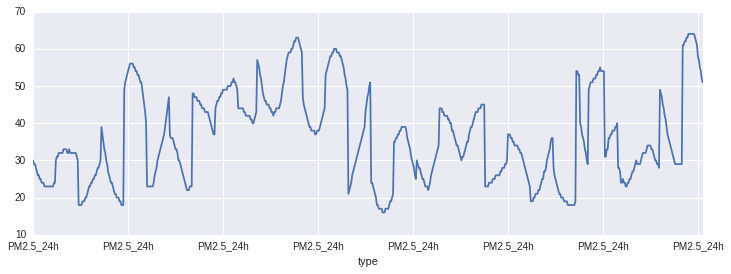

In [160]:
pmcs25["pm25"].plot(figsize=(12,4));

In [161]:
pm25data = pmcs25["pm25"]

In [162]:
pm25data.head()

type
PM2.5_24h    30.0
PM2.5_24h    29.0
PM2.5_24h    29.0
PM2.5_24h    28.0
PM2.5_24h    27.0
Name: pm25, dtype: float64

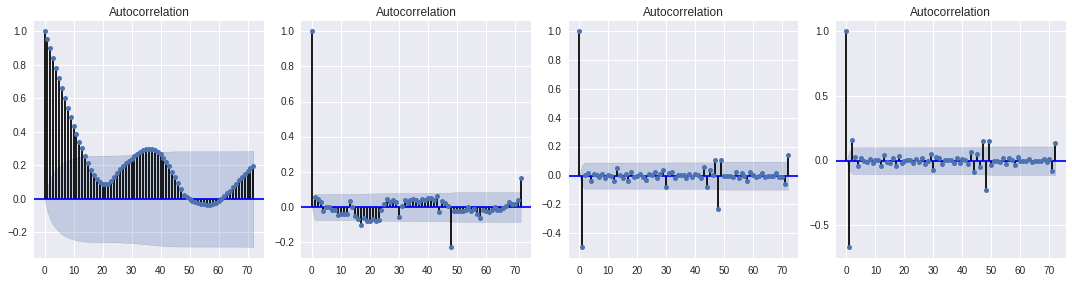

In [163]:
fig, axes = plt.subplots(1,4,figsize=(15,4))

smg.tsa.plot_acf(pm25data, lags=72, ax=axes[0])
smg.tsa.plot_acf(pm25data.diff().dropna(),lags=72,ax=axes[1])
smg.tsa.plot_acf(pm25data.diff().diff().dropna(), lags=72, ax=axes[2])
smg.tsa.plot_acf(pm25data.diff().diff().diff().dropna(), lags=72, ax=axes[3])

fig.tight_layout()

In [187]:
datanew = pd.read_csv("pm2.5new.csv",delimiter=",", encoding=None,header=0)

In [188]:
datanew.head()

,Date,PM2.5
0,2016/05/19 00:00:00,61
1,2016/05/19 01:00:00,61
2,2016/05/19 02:00:00,62
3,2016/05/19 03:00:00,62
4,2016/05/19 04:00:00,63


In [189]:
pm25cs = datanew.set_index("Date")

In [190]:
pm25cs.columns=["pm25"]

In [191]:
pm25cs.index = pd.to_datetime(pm25cs.index)

In [192]:
pm25cs["pm25"]=pm25cs["pm25"].astype(float)

In [193]:
pm25cs.head()

,pm25
Date,
2016-05-19 00:00:00,61.0
2016-05-19 01:00:00,61.0
2016-05-19 02:00:00,62.0
2016-05-19 03:00:00,62.0
2016-05-19 04:00:00,63.0


In [194]:
pm25cs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 706 entries, 2016-05-19 00:00:00 to 2016-06-18 23:00:00
Data columns (total 1 columns):
pm25    706 non-null float64
dtypes: float64(1)
memory usage: 11.0 KB


In [201]:
pm25cs =pm25cs.resample('1D').mean()

In [202]:
pm25cs.head()

,pm25
Date,
2016-05-19,60.590909
2016-05-20,35.625000
2016-05-21,31.208333
2016-05-22,25.750000
2016-05-23,36.142857


In [216]:
pm25cs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2016-05-19 to 2016-06-18
Freq: D
Data columns (total 1 columns):
pm25    31 non-null float64
dtypes: float64(1)
memory usage: 496.0 bytes


### 2.建模

In [221]:
pm25cs_train=pm25cs[0:25]

In [222]:
pm25cs_test=pm25cs[25:]

In [228]:
pm25cs_test

,pm25
Date,
2016-06-13,31.208333
2016-06-14,51.666667
2016-06-15,25.000000
2016-06-16,22.916667
2016-06-17,31.916667
2016-06-18,24.791667


In [203]:
pm25cs_train = pm25cs[pm25cs.index.month==5]

In [204]:
pm25cs_test = pm25cs[pm25cs.index.month==6]

In [205]:
pm25cs_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2016-05-19 to 2016-05-31
Freq: D
Data columns (total 1 columns):
pm25    13 non-null float64
dtypes: float64(1)
memory usage: 208.0 bytes


In [231]:
model = sm.tsa.AR(pm25cs_train.pm25)
#result = model.fit(72)

In [232]:
result = model.fit(maxlag=24,ic='t-stat')

In [233]:
result.predict("2016-06-13","2016-06-18")

2016-06-13    38.812146
2016-06-14    33.898170
2016-06-15    36.874088
2016-06-16    48.043963
2016-06-17    39.136176
2016-06-18    49.278113
Freq: D, dtype: float64

In [184]:
sm.stats.durbin_watson(result.resid)

1.9963049363720766

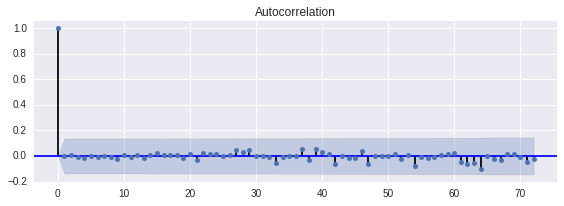

In [185]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

smg.tsa.plot_acf(result.resid, lags=72, ax=ax)

fig.tight_layout()

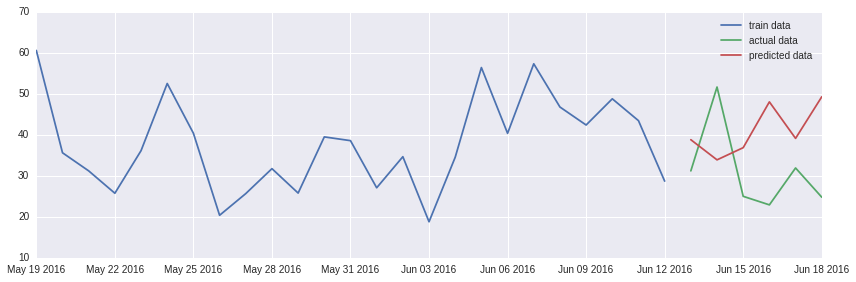

In [234]:
fig, ax = plt.subplots(1,1,figsize=(12,4))

ax.plot(pm25cs_train.index.values, pm25cs_train.values, label="train data")
ax.plot(pm25cs_test.index.values, pm25cs_test.values, label="actual data")
ax.plot(pd.date_range("2016-06-13","2016-06-18", freq="D").values,
        result.predict("2016-06-13", "2016-06-18"), label="predicted data")

ax.legend()
fig.tight_layout()

## Data103 @Jhangsy 的案例

In [520]:
df = pd.read_html('shenyang.html', header=0)

In [521]:
df = df[0]

In [522]:
df.head()

,Reading,Time,PM2.5 level,Concentration
0,1,2016-09-15 0:00,168,89.0
1,2,2016-09-15 1:00,61,17.0
2,3,2016-09-15 2:00,137,50.0
3,4,2016-09-15 3:00,149,55.0
4,5,2016-09-15 4:00,61,17.0


In [523]:
df = df.drop(["Reading", "Concentration"], axis=1)

In [524]:
df.head()

,Time,PM2.5 level
0,2016-09-15 0:00,168
1,2016-09-15 1:00,61
2,2016-09-15 2:00,137
3,2016-09-15 3:00,149
4,2016-09-15 4:00,61


In [525]:
df.tail()

,Time,PM2.5 level
702,2016-10-14 6:00,180
703,2016-10-14 7:00,182
704,2016-10-14 8:00,187
705,2016-10-14 9:00,190
706,2016-10-14 10:00,189


In [526]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 2 columns):
Time           707 non-null object
PM2.5 level    707 non-null object
dtypes: object(2)
memory usage: 11.1+ KB


In [527]:
df['Time'] = pd.to_datetime(df.Time)

In [528]:
df.columns=['Time', 'pm25']

In [529]:
df.head()

,Time,pm25
0,2016-09-15 00:00:00,168
1,2016-09-15 01:00:00,61
2,2016-09-15 02:00:00,137
3,2016-09-15 03:00:00,149
4,2016-09-15 04:00:00,61


In [530]:
df.tail()

,Time,pm25
702,2016-10-14 06:00:00,180
703,2016-10-14 07:00:00,182
704,2016-10-14 08:00:00,187
705,2016-10-14 09:00:00,190
706,2016-10-14 10:00:00,189


In [531]:
df0_pm25 = df.set_index('Time')

In [532]:
# dealing with "(no data)"
df0_pm25[df0_pm25["pm25"]=="(no data)"]=None

In [533]:
df0_pm25["pm25"] = df0_pm25["pm25"].astype(float)

In [534]:
# 必须先转换为数字，再进行插值！！！！

df0_pm25["pm25"] = df0_pm25["pm25"].interpolate(method='time')

In [535]:
df0_pm25

,pm25
Time,
2016-09-15 00:00:00,168.000000
2016-09-15 01:00:00,61.000000
2016-09-15 02:00:00,137.000000
2016-09-15 03:00:00,149.000000
2016-09-15 04:00:00,61.000000
2016-09-15 05:00:00,61.126214
2016-09-15 06:00:00,61.252427
2016-09-15 07:00:00,61.378641
2016-09-15 08:00:00,61.504854


In [179]:
#df0_pm25["pm25"] = df0_pm25["pm25"].astype(float)

In [536]:
model0 = sm.tsa.AR(df0_pm25["pm25"][:-72])
#result = model.fit(72)

In [537]:
result0 = model0.fit(maxlag=72,ic='t-stat')

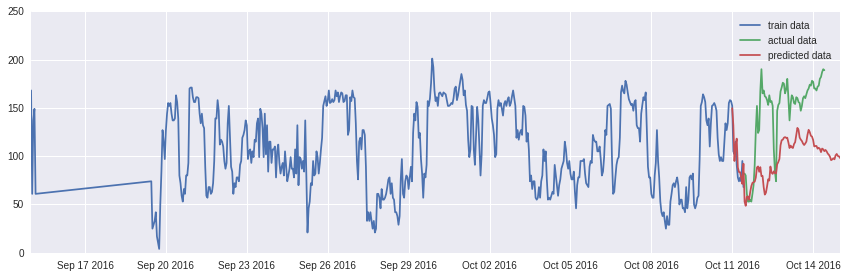

In [539]:
fig, ax = plt.subplots(1,1,figsize=(12,4))

ax.plot(df0_pm25.index.values[:-72], df0_pm25["pm25"].values[:-72], label="train data")
ax.plot(df0_pm25.index.values[-72:], df0_pm25["pm25"].values[-72:], label="actual data")
ax.plot(pd.date_range("2016-10-11","2016-10-15", freq="H").values,
        result0.predict("2016-10-11", "2016-10-15"), label="predicted data")

ax.legend()
fig.tight_layout()

**插值方法换为 quadratic **

In [540]:
df2_pm25 = df.set_index('Time')

In [541]:
# dealing with "(no data)"
df2_pm25[df2_pm25["pm25"]=="(no data)"]=None

In [542]:
df2_pm25["pm25"] = df2_pm25["pm25"].astype(float)

In [543]:
#df2_pm25["pm25"] = df2_pm25["pm25"].interpolate(method="quadratic")
df2_pm25["pm25"] = df2_pm25["pm25"].interpolate()

In [544]:
df2_pm25

,pm25
Time,
2016-09-15 00:00:00,168.000000
2016-09-15 01:00:00,61.000000
2016-09-15 02:00:00,137.000000
2016-09-15 03:00:00,149.000000
2016-09-15 04:00:00,61.000000
2016-09-15 05:00:00,61.126214
2016-09-15 06:00:00,61.252427
2016-09-15 07:00:00,61.378641
2016-09-15 08:00:00,61.504854


In [545]:
model2 = sm.tsa.AR(df2_pm25["pm25"][:-72])
result2 = model2.fit(maxlag=72,ic='t-stat')

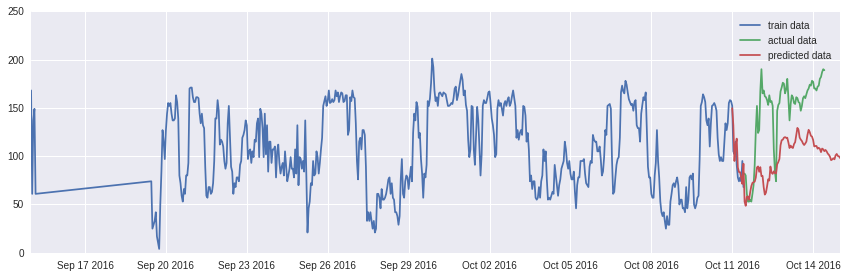

In [546]:
fig, ax = plt.subplots(1,1,figsize=(12,4))

ax.plot(df2_pm25.index.values[:-72], df2_pm25["pm25"].values[:-72], label="train data")
ax.plot(df2_pm25.index.values[-72:], df2_pm25["pm25"].values[-72:], label="actual data")
ax.plot(pd.date_range("2016-10-11","2016-10-15", freq="H").values,
        result2.predict("2016-10-11", "2016-10-15"), label="predicted data")

ax.legend()
fig.tight_layout()

**按 fillna 插值**

In [556]:
df1_pm25 = df.set_index('Time')

In [557]:
# dealing with "(no data)"
df1_pm25[df1_pm25["pm25"]=="(no data)"]=None

In [558]:
# fill none with forward
df1_pm25["pm25"]=df1_pm25["pm25"].fillna(method="ffill")

In [559]:
df1_pm25["pm25"] = df1_pm25["pm25"].astype(float)

In [560]:
df1_pm25.head()

,pm25
Time,
2016-09-15 00:00:00,168.0
2016-09-15 01:00:00,61.0
2016-09-15 02:00:00,137.0
2016-09-15 03:00:00,149.0
2016-09-15 04:00:00,61.0


In [561]:
model1 = sm.tsa.AR(df1_pm25["pm25"][:-72])

In [562]:
result1 = model1.fit(maxlag=72,ic='t-stat')

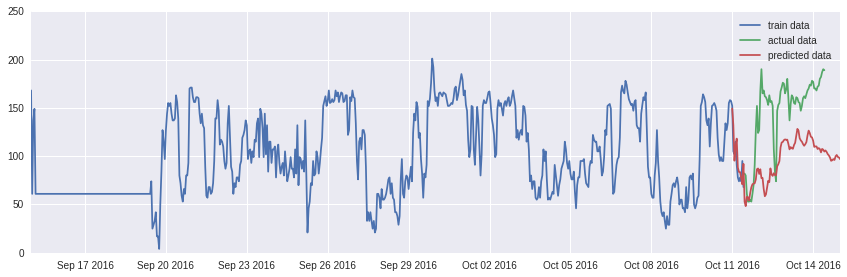

In [563]:
fig, ax = plt.subplots(1,1,figsize=(12,4))

ax.plot(df1_pm25.index.values[:-72], df1_pm25["pm25"].values[:-72], label="train data")
ax.plot(df1_pm25.index.values[-72:], df1_pm25["pm25"].values[-72:], label="actual data")
ax.plot(pd.date_range("2016-10-11","2016-10-15", freq="H").values,
        result1.predict("2016-10-11", "2016-10-15"), label="predicted data")

ax.legend()
fig.tight_layout()

**剔除异常值，按线性插值法预测看看**

In [564]:
df3_pm25 = df[107:].set_index('Time')

In [565]:
# dealing with "(no data)"
df3_pm25[df3_pm25["pm25"]=="(no data)"]=None

In [566]:
df3_pm25["pm25"] = df3_pm25["pm25"].astype(float)

In [567]:
#df2_pm25["pm25"] = df2_pm25["pm25"].interpolate(method="quadratic")
df3_pm25["pm25"] = df3_pm25["pm25"].interpolate()

In [568]:
model3 = sm.tsa.AR(df3_pm25["pm25"][:-72])
result3 = model3.fit(maxlag=72,ic='t-stat')

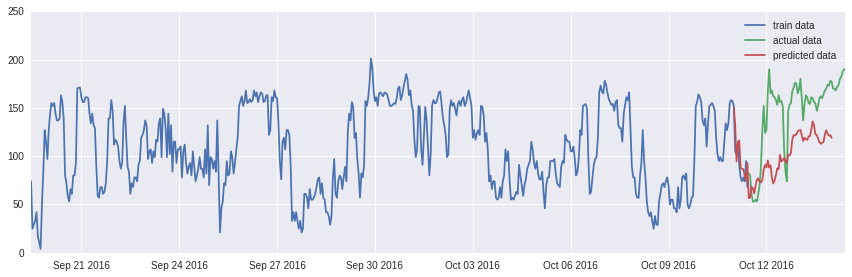

In [569]:
fig, ax = plt.subplots(1,1,figsize=(12,4))

ax.plot(df3_pm25.index.values[:-72], df3_pm25["pm25"].values[:-72], label="train data")
ax.plot(df3_pm25.index.values[-72:], df3_pm25["pm25"].values[-72:], label="actual data")
ax.plot(pd.date_range("2016-10-11","2016-10-14", freq="H").values,
        result3.predict("2016-10-11", "2016-10-14"), label="predicted data")

ax.legend()
fig.tight_layout()

>关于 interpolate，参考至：http://jingyan.baidu.com/season/43456 第 25 篇。

## 补充：ARIMA模型

### 4.1 读取数据

In [576]:
pmcs_add = pd.read_csv("pm2.5new.csv", delimiter=",", encoding=None, header=0)

### 4.2 预处理

In [577]:
pmcs_add = datanew.set_index("Date")
pmcs_add.index = pd.to_datetime(pmcs_add.index)

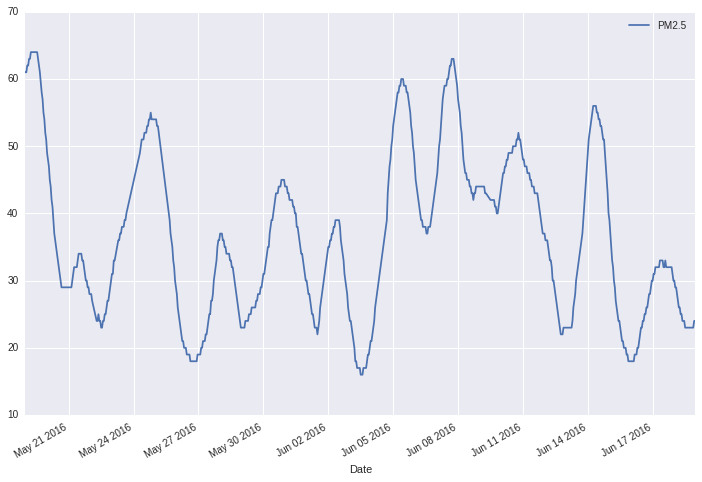

In [578]:
pmcs_add.plot(figsize=(12,8))

### 4.3 差分

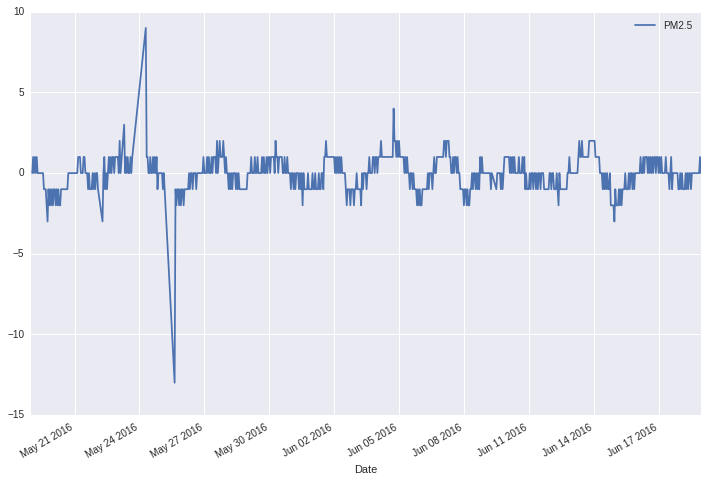

In [624]:
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(111)
diff1 = pmcs_add.diff(1)
diff1.plot(ax=ax1);

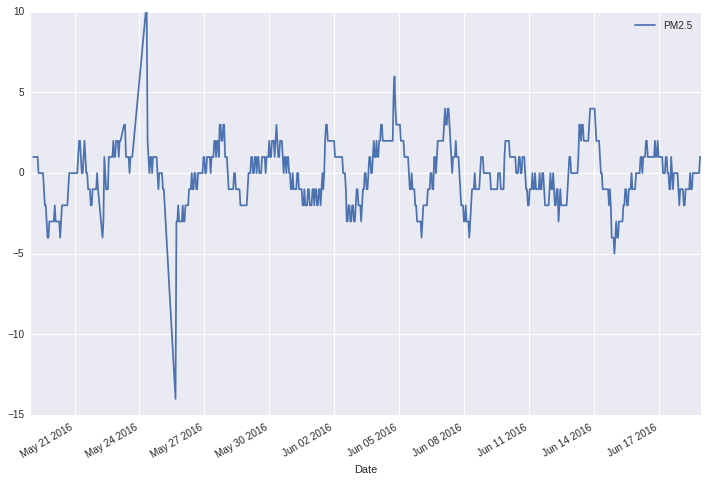

In [580]:
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(111)
diff2 = pmcs_add.diff(2)
diff2.plot(ax=ax1);

一阶差分，二阶差分后与原图相差不大。因此，选d=0.

### 4.4 确定pq

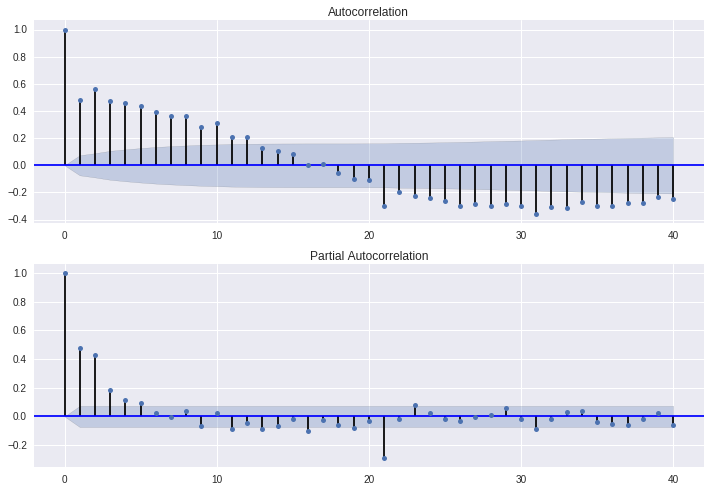

In [636]:
#pmcs_add_new = pmcs_add

pmcs_add_new = pmcs_add.diff(1).dropna()

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = smg.tsa.plot_acf(pmcs_add_new,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = smg.tsa.plot_pacf(pmcs_add_new,lags=40,ax=ax2)

In [651]:
model1 = sm.tsa.ARMA(pmcs_add_new,(6,0)).fit([6,0])
print(model1.aic,model1.bic,model1.hqic);

model2 = sm.tsa.ARMA(pmcs_add_new,(6,1)).fit()
print(model2.aic,model2.bic,model2.hqic);

model3 = sm.tsa.ARMA(pmcs_add_new,(6,3)).fit()
print(model3.aic,model3.bic,model3.hqic);

model4 = sm.tsa.ARMA(pmcs_add_new,(7,3)).fit()
print(model4.aic,model4.bic,model4.hqic);       # 最佳2

model5 = sm.tsa.ARMA(pmcs_add_new,(8,3)).fit()
print(model5.aic,model5.bic,model5.hqic);

model6 = sm.tsa.ARMA(pmcs_add_new,(7,2)).fit()  # 最佳
print(model6.aic,model6.bic,model6.hqic); 

model7 = sm.tsa.ARMA(pmcs_add_new,(7,1)).fit()
print(model7.aic,model7.bic,model7.hqic); 

/home/evil_rabbit/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4579.11955575394, 4615.5851381764387, 4593.2110091944378)
(1808.3886958407024, 1849.4124760660129, 1824.2415809612617)


/home/evil_rabbit/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1791.6251400698557, 1841.7653159007907, 1811.000888550539)


/home/evil_rabbit/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1781.1450355330328, 1835.84340916678, 1802.2822156937784)


/home/evil_rabbit/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1820.20024436984, 1879.4568158063994, 1843.0988562106477)


/home/evil_rabbit/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1779.9247496055923, 1830.0649254365273, 1799.3004980862756)
(1789.4709159919184, 1835.0528940200411, 1807.0852327925397)


### 4.5 检验

#### 4.5.1 残差自相关图

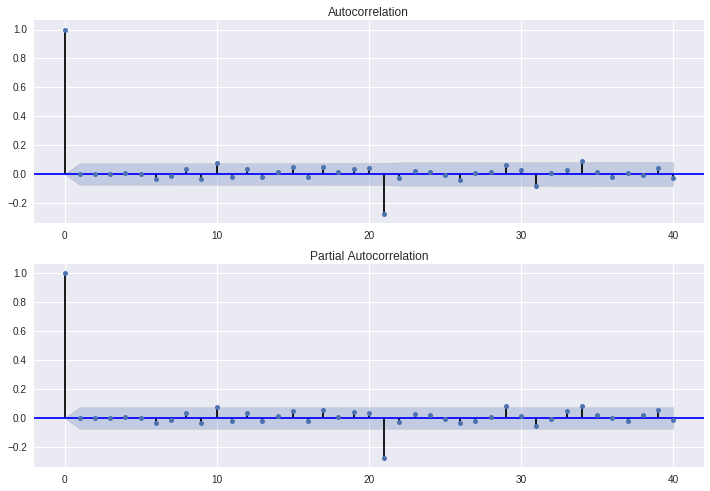

In [656]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = smg.tsa.plot_acf(model6.resid.values.squeeze(), lags=40, ax=ax1)

ax2 = fig.add_subplot(212)
fig = smg.tsa.plot_pacf(model6.resid, lags=40, ax=ax2)

#### 4.5.1 DW检验

In [657]:
sm.stats.durbin_watson(model6.resid)

1.9978353437643306

In [658]:
sm.stats.durbin_watson(model5.resid)

2.0027760335053602

#### 4.5.1 正态检验

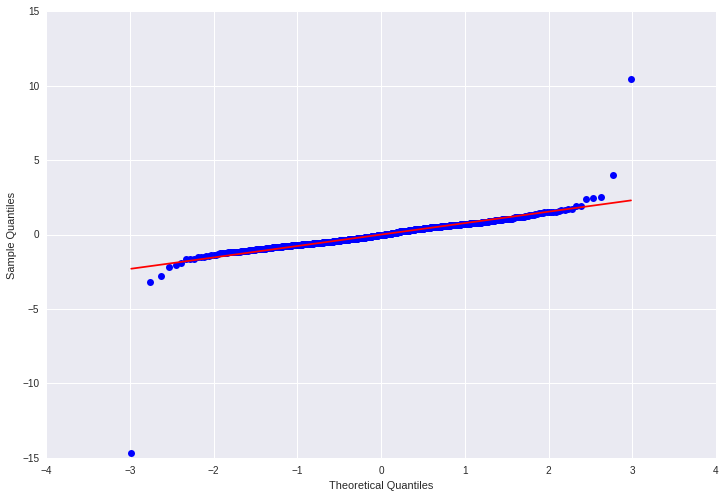

In [660]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = smg.qqplot(model6.resid, line='q', ax=ax, fit=True)

#### 4.5.1 LBQ检验

In [661]:
r,q,p = sm.tsa.acf(model6.resid.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q      Prob(>Q)
lag                                    
1.0   0.000993   0.000698  9.789225e-01
2.0   0.000527   0.000895  9.995525e-01
3.0  -0.000242   0.000937  9.999924e-01
4.0   0.004017   0.012413  9.999808e-01
5.0   0.000913   0.013007  9.999990e-01
6.0  -0.031848   0.736274  9.936745e-01
7.0  -0.017368   0.951670  9.955709e-01
8.0   0.031032   1.640298  9.901260e-01
9.0  -0.034791   2.507124  9.806913e-01
10.0  0.075245   6.567569  7.655405e-01
11.0 -0.021561   6.901436  8.070083e-01
12.0  0.034137   7.739604  8.051341e-01
13.0 -0.022161   8.093327  8.374675e-01
14.0  0.014230   8.239383  8.764854e-01
15.0  0.048992   9.973214  8.214214e-01
16.0 -0.024381  10.403230  8.447398e-01
17.0  0.051610  12.332954  7.795698e-01
18.0  0.014007  12.475296  8.217537e-01
19.0  0.032297  13.233188  8.264224e-01
20.0  0.040240  14.411439  8.090376e-01
21.0 -0.277829  70.659424  2.753754e-07
22.0 -0.024390  71.093562  4.445634e-07
23.0  0.022340  71.458296  7.226385e-07


### 4.6 预测

In [688]:
#ptime = pd.date_range("2016-06-18", "2016-06-20", freq="H").values
#ptime = pd.to_datetime(ptime, unit="s")

In [700]:
predict_pm = model6.predict('2016-06-18', '2016-06-20')  # 原始数据有遗漏，导致程序运行错误。换成月度数据进行预测。
print(predict_pm)
fig, ax = plt.subplots(figsize=(12, 8))
ax = pmcs_add.ix['2016/05/19 00:00:00':].plot(ax=ax)
predict_pm.plot(ax=ax)

ValueError: Must provide freq argument if no data is supplied

### 原始数据有遗漏，导致预测时报错。换成月度数据进行预测。将小时数据平均后换为月数据

In [706]:
pmcs_byday = pd.read_csv("pm2.5new.csv", delimiter=",", encoding=None, header=0)

In [707]:
pmcs_byday =pmcs_byday.set_index("Date")
pmcs_byday.index = pd.to_datetime(pmcs_byday.index)
pmcs_byday =pmcs_byday.resample('1D').mean()

In [753]:
pmcs_byday.head()

,PM2.5
Date,
2016-05-19,60.590909
2016-05-20,35.625000
2016-05-21,31.208333
2016-05-22,25.750000
2016-05-23,36.142857


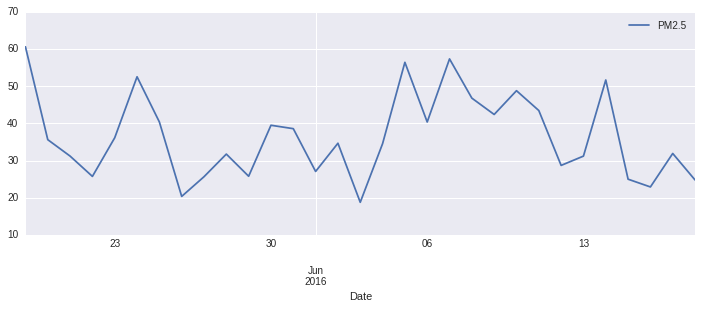

In [709]:
pmcs_byday.plot(figsize=(12,4));

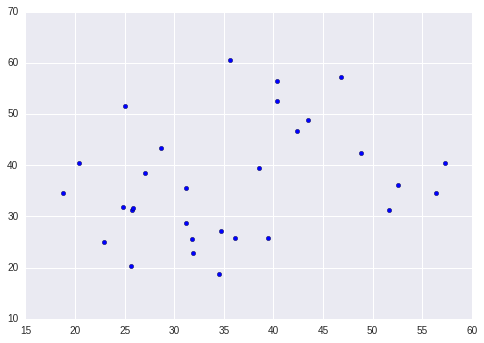

In [711]:
plt.scatter(pmcs_byday[1:], pmcs_byday[:-1]);

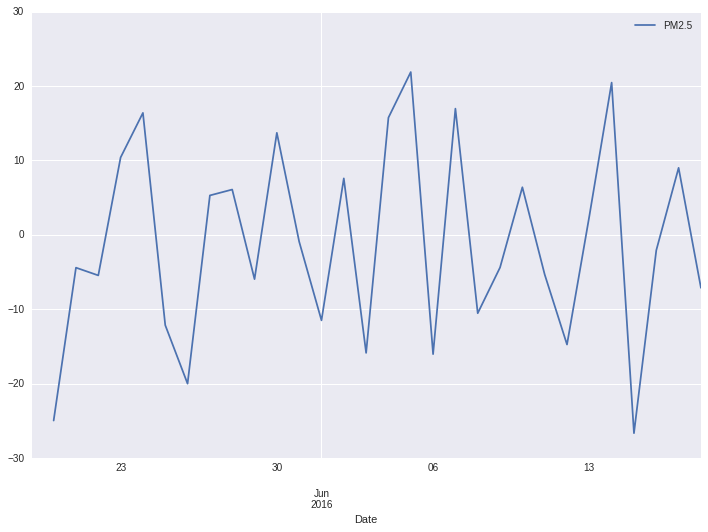

In [712]:
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(111)
diff1_byday = pmcs_byday.diff(1)
diff1_byday.plot(ax=ax1);

由上可知：$d=0$

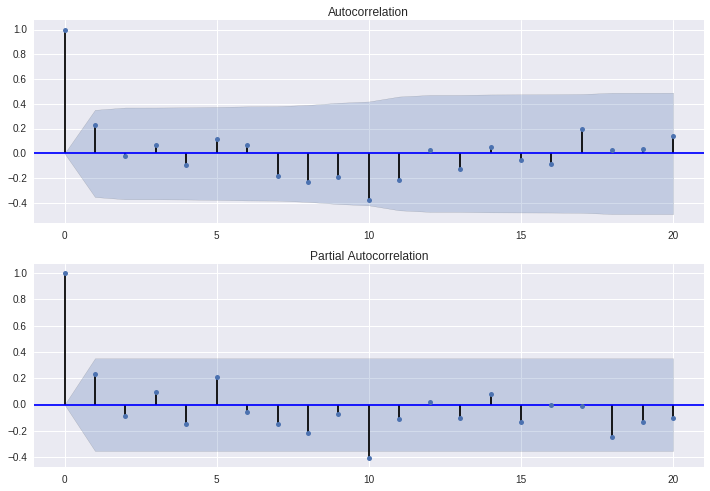

In [719]:
pmcs_byday_new = pmcs_byday
#pmcs_byday_new = pmcs_byday.diff(1).dropna()

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = smg.tsa.plot_acf(pmcs_byday_new,lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = smg.tsa.plot_pacf(pmcs_byday_new,lags=20,ax=ax2)

In [741]:
model1 = sm.tsa.ARMA(pmcs_byday,(1,1)).fit()  # 最优 d=0,p=1,q=1
print(model1.aic,model1.bic,model1.hqic);

model2 = sm.tsa.ARMA(pmcs_byday,(1,0)).fit([1,0])
print(model2.aic,model2.bic,model2.hqic);

model3 = sm.tsa.ARMA(pmcs_byday,(0,0)).fit()
print(model3.aic,model3.bic,model3.hqic);

model4 = sm.tsa.ARMA(pmcs_byday,(0,1)).fit()
print(model4.aic,model4.bic,model4.hqic);

(238.48687133532883, 244.22282015326942, 240.35664762607183)
(241.91355936783555, 246.21552098129098, 243.31589158589279)
(241.96064407792355, 244.82861848689384, 242.89553222329505)
(241.0884553823592, 245.39041699581463, 242.49078760041644)


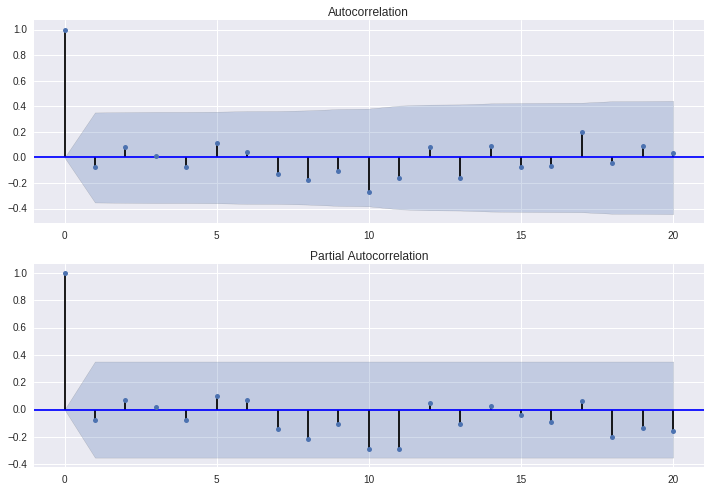

In [742]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = smg.tsa.plot_acf(model1.resid.values.squeeze(), lags=20, ax=ax1)


ax2 = fig.add_subplot(212)
fig = smg.tsa.plot_pacf(model1.resid, lags=20, ax=ax2)

In [752]:
sm.stats.durbin_watson(model1.resid)

1.9556730183824123

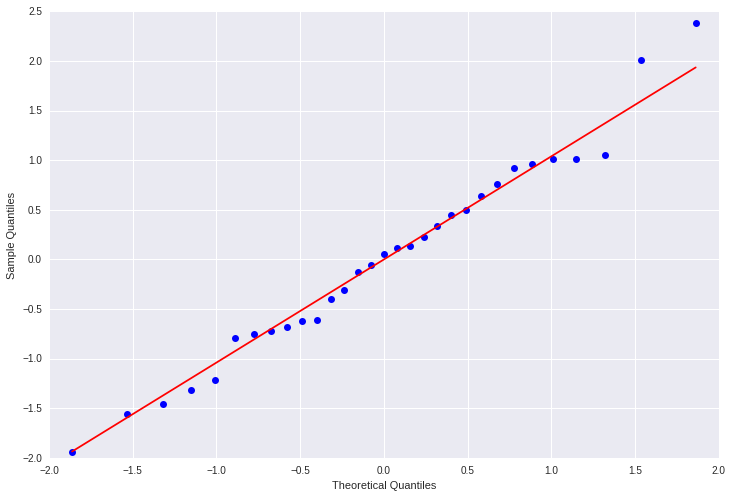

In [744]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = smg.qqplot(model1.resid, line='q', ax=ax, fit=True)

2016-06-19    33.840989
2016-06-20    37.854241
2016-06-21    36.214061
2016-06-22    36.884388
Freq: D, dtype: float64


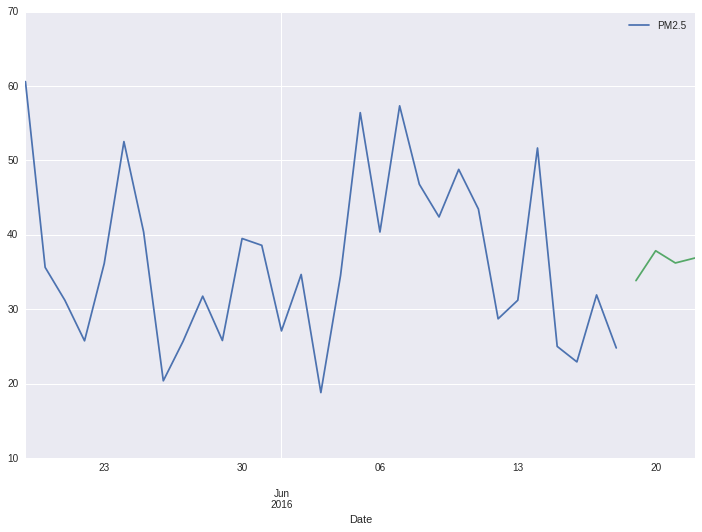

In [751]:
predict_pm_byday = model1.predict('2016-6-19', '2016-6-22', dynamic=True)
print(predict_pm_byday)
fig, ax = plt.subplots(figsize=(12, 8))
ax = pmcs_byday.ix['2016-5-19':].plot(ax=ax)
predict_pm_byday.plot(ax=ax)

### 4.7 小结  

1. 时间序列数据要尽可能保持完整，否则可能会导致无法预测（数据跳跃，非周期）。  
2. 时间序列必须先进行平稳性检验，只有平稳的序列才可以进行分析。  
3. 检验非平稳序列的方法有很多，如DF，ADF，PP，KPSS，ERS，NP等，要注意各种方法的条件和注意事项。  
4. DW，QQ图，LM，是检验序列相关的方法。前提是数据序列本身是平稳的。